# Tensor Completion for Estimating Missing Values in Visual Data

This notebook shows how to implement a HaLRTC imputer on image data sets. The HaLRTC algorithm applies the alternating direction method of multipliers (ADMMs) to nuclear norm minimization problem. For an in-depth discussion of HaLRTC, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> J. Liu, P. Musialski, P. Wonka and J. Ye (2014). <b>Tensor Completion for Estimating Missing Values in Visual Data</b>. IEEE Transactions on Pattern Analysis and Machine Intelligence. <a href="https://www.peterwonka.net/Publications/pdfs/2009.ICCV.Ji.TensorCompletion.Final.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>


## Selected Images

We carry out our image inpainting experiments on the following images.

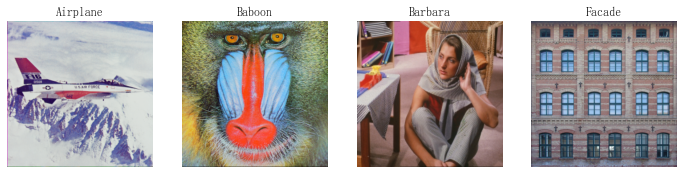

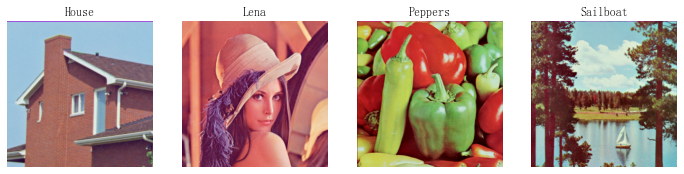

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('datasets/color-images/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('datasets/color-images/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('datasets/color-images/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('datasets/color-images/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('datasets/color-images/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('datasets/color-images/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('datasets/color-images/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('datasets/color-images/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## HaLRTC

We start by importing the necessary dependencies.

In [2]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

In [3]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [4]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Soft Thresholding Method

Here, we use nuclear norm regularization to approximate rank function.

Reference:

Ryan Tibshirani, 2015. Lecture on Proximal Gradient Descent. [[**link**](http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)]

In [5]:
def svt(mat, lambda0): ## Singular value thresholding (SVT)
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - lambda0
    vec[np.where(vec < 0)] = 0
    
    return np.matmul(np.matmul(u, np.diag(vec)), v)

In [6]:
def HaLRTC(dense_tensor, sparse_tensor, alpha, rho, maxiter):
    
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(svt(ten2mat(tensor_hat + T[:, :, :, k] / rho, k), 
                                        alpha / rho), np.array([dim1, dim2, dim3]), k)
        tensor_hat = np.mean(Z - T / rho, axis = 3)
        tensor_hat[position] = sparse_tensor[position]
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (tensor_hat - Z[:, :, :, k])

    return tensor_hat

## Experiments on Color Images

In the following, we will illustrate the performance of image inpainting tasks using Geometric Low-rank Tensor Completion (GLTC) model on some color images.

We set the missing scenario as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we run the code for 10 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

In [7]:
name0 = ["peppers"]
name = ["peppers_mar"]
image = imageio.imread('datasets/color-images/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('datasets/color-images/{}.bmp'.format(name[0]))

In [8]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time

alpha = 1
rho = 0.01
maxiter = 1000
start = time.time()
image_hat = HaLRTC(image, sparse_image, alpha, rho, maxiter)
end = time.time()
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
print(100 * rse)
print()
print('Running time: %d seconds.'%(end - start))

11.654246712985247

Running time: 95 seconds.


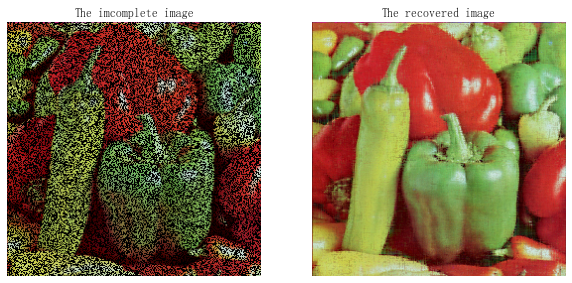

In [9]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

### Whole Performance

We choose the images of `house`, `lena`, `peppers`, and `sailboat` for evaluation.

#### MAR (Missing at random)

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

alpha = 1
rho = 0.01
maxiter = 1000

im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('datasets/color-images/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = HaLRTC(image, sparse_image, alpha, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [ ]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)